In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scanpy
!pip install infercnvpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 132.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import scanpy as sc
from anndata import AnnData
import pandas as pd

def add_gene_positions_to_adata(adata: AnnData, gene_pos_df: pd.DataFrame) -> AnnData:
    """
    Write the 'chromosome', 'start', and 'end' information from gene_pos_df into AnnData.var.

    Parameters
    ----------
    adata : AnnData
        The original AnnData object, where var_names are aligned with gene_pos_df.index.
    gene_pos_df : pd.DataFrame
        A DataFrame containing gene position information. The index should be gene names,
        and columns must include 'chromosome', 'start', and 'end'.

    Returns
    -------
    adata_new : AnnData
        A copy of the input AnnData object, with three new columns added to .var:
        'chromosome', 'start', and 'end'.
    """
    # Check if the indices match
    if not gene_pos_df.index.equals(adata.var_names):
        # Attempt to reindex or align
        try:
            gene_pos_df = gene_pos_df.reindex(adata.var_names)
        except Exception as e:
            raise ValueError(f"Failed to align gene_pos_df.index with adata.var_names: {e}")

    # Create a copy of the AnnData object
    adata_new = adata.copy()

    # Assign position information directly to .var
    adata_new.var['chromosome'] = gene_pos_df['chromosome'].values
    adata_new.var['start']      = gene_pos_df['start'].values
    adata_new.var['end']        = gene_pos_df['end'].values

    return adata_new

In [4]:
import scanpy as sc
train_path = '/content/drive/MyDrive/stemcell/final_project/PBMC_simulated_cnas_041025.h5ad'

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/stemcell/final_project/final_project')

In [6]:
import scancnv

In [7]:
from scancnv.infer import infer_cnv_and_annotate
from scancnv.infer import annotate_cnv
from scancnv.filter_genes import filter_genes_by_chromosome
from scancnv.annotate import annotate_normal_cells
from scancnv.subset import subset_shared_genes
from scancnv.assess import assess_cnv

simulate gold standard dataset

In [156]:
import numpy as np
import pandas as pd
from anndata import AnnData, concat


def generate_simulated_cnv_adata(
    adata: AnnData,
    gene_pos_df: pd.DataFrame,
    normal_key: str = 'simulated_cnvs',
    celltype_key: str = 'cell_type',
    n_genes: int = 50,
    n_mutated_per_level: dict = None,
    fc_map: dict = None,
    cn_map: dict = None,
    seed: int = None
) -> AnnData:
    """
    Generate simulated CNV cells from normal cells. For each level, two fixed intervals are used 
    (two segments per level), and the mutated cells are merged with the original normal cells.
    If adata contains layers['counts'], the mutation is applied to that layer; otherwise, it's applied to X.
    New simulated cells will have unique obs_names by appending a suffix.

    Parameters
    ----------
    adata : AnnData
        The original AnnData object. Cells with empty strings in obs[normal_key] are treated as normal.
    gene_pos_df : DataFrame
        A DataFrame indexed by gene names, with columns: ['chromosome', 'start', 'end'].
    normal_key : str
        Column name in obs used for storing simulated CNV annotations.
    celltype_key : str
        Column name in obs that stores cell type annotations.
    n_genes : int
        Number of genes in each simulated CNV segment.
    n_mutated_per_level : dict
        Number of mutated cells to generate per CNV level, e.g., {'high':1500,'medium':800,'low':300}.
    fc_map : dict
        Fold-change applied to gene expression per level, e.g., {'high':2.0,'medium':0.5,'low':0.25}.
    cn_map : dict
        Copy number annotation per level, e.g., {'high':4,'medium':1,'low':0}.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    AnnData
        A new AnnData object containing the original normal cells and the newly simulated CNV cells.
    """
    # Default parameters
    if n_mutated_per_level is None:
        n_mutated_per_level = {'high': 1500, 'medium': 800, 'low': 300}
    if fc_map is None:
        fc_map = {'high': 2.0, 'medium': 0.5, 'low': 0.25}
    if cn_map is None:
        cn_map = {'high': 4, 'medium': 1, 'low': 0}

    rng = np.random.default_rng(seed)

    # Filter for normal cells and ensure annotation column is of string type
    mask_normal = adata.obs[normal_key] == ''
    adata_normal = adata[mask_normal].copy()
    adata_normal.obs[normal_key] = adata_normal.obs[normal_key].astype(str)

    # Check for 'counts' layer
    has_counts = 'counts' in adata.layers

    # Get autosomes
    autosomes = [c for c in gene_pos_df['chromosome'].unique() if c not in ('X', 'Y')]
    if not autosomes:
        raise ValueError('No autosomes detected.')

    # Randomly assign a cell type to each CNV level
    celltypes = adata_normal.obs[celltype_key].unique().tolist()
    levels = list(n_mutated_per_level.keys())
    rng.shuffle(celltypes)
    assign = dict(zip(levels, celltypes[:len(levels)]))

    mutated_cells = []
    var_names = list(adata.var_names)
    unique_counter = 0

    # For each CNV level, generate two segments and corresponding mutated cells
    for level, total_count in n_mutated_per_level.items():
        assigned_ct = assign.get(level)
        idxs = np.where((adata.obs[celltype_key] == assigned_ct) & mask_normal)[0]
        if len(idxs) == 0:
            continue
        fc = fc_map[level]
        cn_val = cn_map[level]
        n_intervals = 2
        per_interval = total_count

        for _ in range(n_intervals):
            # Randomly select a genomic interval from an autosome
            chrom = rng.choice(autosomes)
            genes_chr = gene_pos_df[gene_pos_df['chromosome'] == chrom].sort_values('start')
            if len(genes_chr) < n_genes:
                raise ValueError(f"Chromosome {chrom} has fewer than {n_genes} genes.")
            start_i = rng.integers(0, len(genes_chr) - n_genes + 1)
            seg = genes_chr.iloc[start_i:start_i + n_genes]
            gene_idx = [var_names.index(g) for g in seg.index]
            start_pos, end_pos = seg['start'].iloc[0], seg['end'].iloc[-1]
            annotation = f"{chrom}:{start_pos}-{end_pos} (CN {cn_val})"

            # Generate mutated cells
            picks = rng.choice(idxs, size=per_interval, replace=True)
            for idx in picks:
                unique_counter += 1
                orig_obs = adata.obs_names[idx]
                cell = adata[idx].copy()
                # Ensure unique obs_name
                cell.obs_names = [f"{orig_obs}_sim{unique_counter}"]
                cell.obs[normal_key] = cell.obs[normal_key].astype(str)

                # Modify counts or X
                if has_counts:
                    arr = cell.layers['counts'].toarray() if hasattr(cell.layers['counts'], 'toarray') else cell.layers['counts'].copy()
                    arr[0, gene_idx] *= fc
                    cell.layers['counts'] = arr
                    cell.X = arr
                else:
                    if hasattr(cell.X, 'tocsc'):
                        cell.X = cell.X.toarray()
                    cell.X[0, gene_idx] *= fc

                # Update CNV annotation
                cell.obs.iloc[0, cell.obs.columns.get_loc(normal_key)] = annotation
                mutated_cells.append(cell)

    # Concatenate normal and mutated cells
    new_adata = concat([adata_normal] + mutated_cells, axis=0)
    return new_adata

In [157]:
import math
adata = sc.read(train_path)
adata = filter_genes_by_chromosome(adata)
min_cells = math.ceil(adata.n_obs * 0.3)
sc.pp.filter_genes(adata, min_cells=min_cells)
gene_pos_df = adata.var[['chromosome', 'start', 'end']]

In [195]:
new_adata = generate_simulated_cnv_adata(
    adata=adata,
    gene_pos_df=gene_pos_df,
    normal_key='simulated_cnvs',
    celltype_key='cell_type',
    n_genes=20,
    n_mutated_per_level={'high':1000,'medium':500,'low':200},
    fc_map={'high':20.0,'medium':0.5,'low':0},
    cn_map={'high':4,'medium':1,'low':0},
    seed=40
)

In [196]:
new_adata.obs['simulated_cnvs'] = (
    new_adata.obs['simulated_cnvs']
    .astype(str)
    .str.replace(r'(\d+)\.0', r'\1', regex=True)
)

In [180]:
new_adata = add_gene_positions_to_adata(new_adata, gene_pos_df)
new_adata_chr = new_adata[new_adata.obs['cell_type'] == 'B cell'].copy()
new_adata_chr = new_adata_chr[:,new_adata_chr.var['chromosome']=='2'].copy()

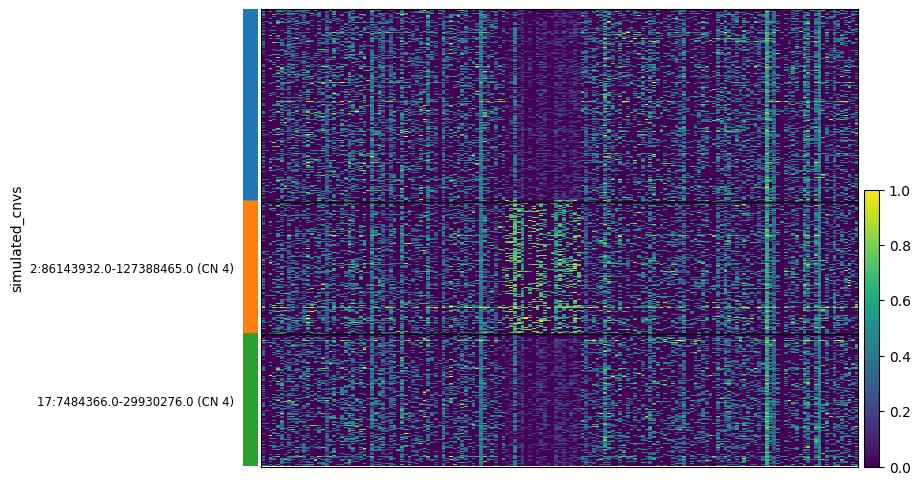

In [181]:
sc.pl.heatmap(new_adata_chr, new_adata_chr.var_names, groupby='simulated_cnvs',layer="counts", log=True, standard_scale='var')

原始计数分布：
simulated_cnvs         13:45954465.0-108308484.0 (CN 0)  \
cell_type                                                 
B cell           1450                                 0   
CD14 monocyte     862                                 0   
CD4 T cell       1823                                 0   
CD8 T cell       1029                               200   
Dendritic         154                                 0   
FCGR3A monocyte   327                                 0   
Megakaryocyte      59                                 0   
NK cell           608                                 0   

simulated_cnvs   15:51829628.0-72376420.0 (CN 1)  \
cell_type                                          
B cell                                         0   
CD14 monocyte                                  0   
CD4 T cell                                     0   
CD8 T cell                                     0   
Dendritic                                    500   
FCGR3A monocyte                      

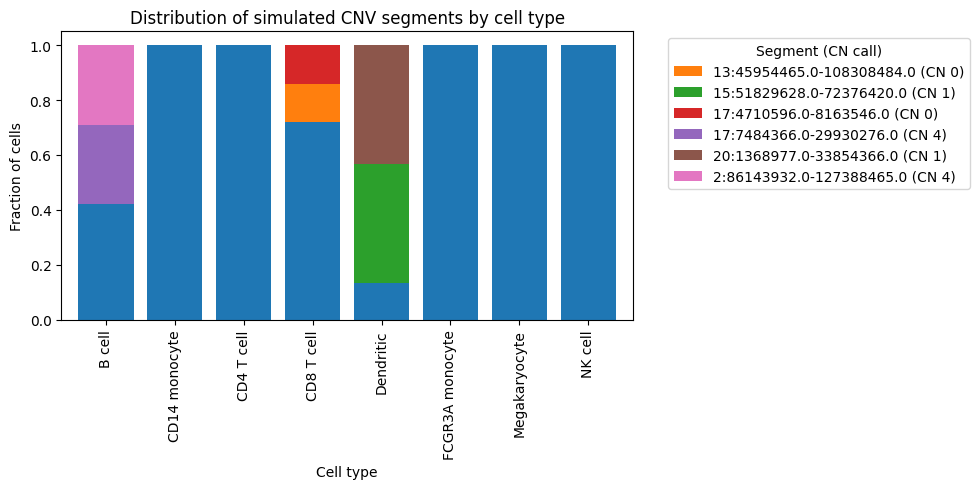

In [177]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the DataFrame
df = new_adata.obs[['cell_type', 'simulated_cnvs']].copy()
df['simulated_cnvs'] = df['simulated_cnvs'].fillna('')  # Empty string indicates no CNV

# 1. Compute the count distribution for each cell type × CNV segment
count_dist = pd.crosstab(df['cell_type'], df['simulated_cnvs'])
print("Original count distribution:")
print(count_dist)

# 2. Compute percentage distribution
pct_dist = count_dist.div(count_dist.sum(axis=1), axis=0).round(3)
print("\nPercentage distribution:")
print(pct_dist)

# 3. Visualization: stacked bar plot showing the percentage distribution
pct_dist.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 5),
    width=0.8
)
plt.ylabel('Fraction of cells')
plt.xlabel('Cell type')
plt.title('Distribution of simulated CNV segments by cell type')
plt.legend(title='Segment (CN call)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
new_adata = add_gene_positions_to_adata(new_adata, gene_pos_df)

In [197]:

shared_genes = new_adata_chr.var_names.intersection(gene_pos_df.index)

new_adata_chr = new_adata_chr[:, shared_genes].copy()
gene_pos_df = gene_pos_df.loc[shared_genes].copy()

/content/drive/MyDrive/stemcell/final_project/final_project/scancnv/infer.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, grp in gene_pos_df.groupby("chromosome"):
/content/drive/MyDrive/stemcell/final_project/final_project/scancnv/infer.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  baseline_df = win_df[is_ref].groupby(ct[is_ref]).mean()


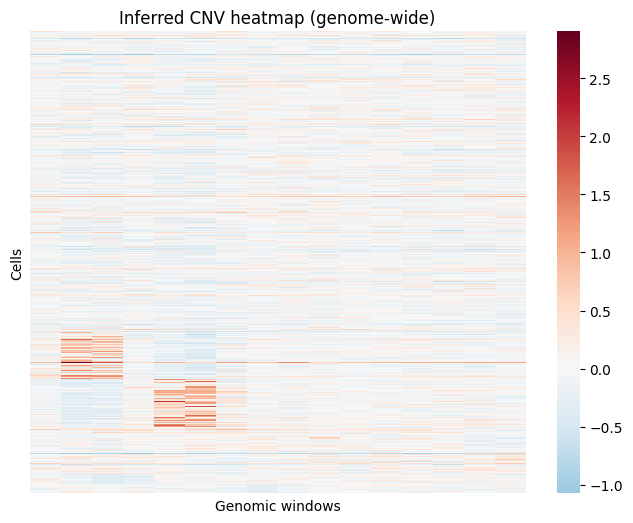

In [199]:
cnv_scores = infer_cnv_and_annotate(
    new_adata,
    gene_pos_df,
    celltype_key="cell_type",
    window_size=10,
    thresh_del=-1,
    thresh_half=-0.5,
    thresh_gain=1,
    min_cells=10,
    min_annots=10
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(
    cnv_scores,
    cmap="RdBu_r",
    center=0,
    yticklabels=False,
    xticklabels=False
)
plt.xlabel("Genomic windows")
plt.ylabel("Cells")
plt.title("Inferred CNV heatmap (genome-wide)")
plt.show()

In [203]:
assess_cnv(new_adata)

Accuracy:    0.692
Precision:   0.710
Sensitivity: 0.205


{'TP': 696,
 'FP': 284,
 'FN': 2704,
 'TN': 6028,
 'accuracy': 0.692339373970346,
 'precision': 0.710204081632653,
 'sensitivity': 0.20470588235294118}